In [1]:
%load_ext autoreload
%autoreload 2

Data Preprocessing and Loading

In [2]:
from src.data.data import DataProcessor, TimeSeriesDataset, TimeSeriesDataLoader

# Preprocess data
data_processor = DataProcessor(start='2021-03-25 00:00:00', 
                               end='2021-03-31 00:00:00', 
                               verbose=True)
data_processor.prepare_data(filename='bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', 
                            exclude_columns_detrend=['SMA', 'RSI', 'MACD', 'log_ret', 'percent_ret'],
                            exclude_columns_scale=[''])

# Create dataloaders
train_loader, val_loader, test_loader = data_processor.create_dataloaders(window=60, 
                                                                          batch_size=128,
                                                                          exclude_input_columns=['percent_ret'])

data_processor.databundle.train.head()

Data loaded --------- data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
Using data from 2020-03-31 00:00:00 to 2021-03-31 00:00:00 with 525600 rows and 12 columns


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,SMA,RSI,MACD,log_ret,percent_ret
Timestamp,,,,,,,,,,,,
2020-03-31 00:00:00,0.386341,0.384774,0.385301,0.384527,0.000328,0.003033,0.384227,0.017614,0.320169,0.685930,0.519628,0.508936
2020-03-31 00:01:00,0.385020,0.384380,0.385471,0.385526,0.003681,0.005287,0.384560,0.017514,0.370988,0.686233,0.551603,0.540999
2020-03-31 00:02:00,0.386348,0.386972,0.386856,0.388220,0.017017,0.014283,0.386968,0.017452,0.482987,0.690373,0.574384,0.563896
2020-03-31 00:03:00,0.387491,0.387713,0.388002,0.388424,0.006512,0.007205,0.387528,0.017389,0.490484,0.694151,0.540866,0.530223
2020-03-31 00:04:00,0.388706,0.388822,0.388938,0.390102,0.008228,0.008369,0.388490,0.017396,0.547845,0.699569,0.560651,0.550087


Initialize model

In [3]:
from torchinfo import summary
from src.model.lstm import LSTM

# Input dimension
sample_batch = next(iter(train_loader))
sample_x, _ = sample_batch
input_dim = sample_x.shape[2] 

# Initialize model
model = LSTM(input_dim=input_dim, 
             hidden_dim=256, 
             output_dim=1, 
             num_layers=2, 
             fc_hidden_dim=256,
             use_hn=False, 
             dropout=0.5,
             maintain_state=True)

# Print model summary
print(summary(model, input_data=sample_x))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [128, 1]                  --
├─LSTM: 1-1                              [128, 60, 256]            801,792
├─Sequential: 1-2                        [128, 1]                  --
│    └─Linear: 2-1                       [128, 256]                65,792
│    └─ReLU: 2-2                         [128, 256]                --
│    └─Linear: 2-3                       [128, 1]                  257
Total params: 867,841
Trainable params: 867,841
Non-trainable params: 0
Total mult-adds (G): 6.17
Input size (MB): 0.34
Forward/backward pass size (MB): 15.99
Params size (MB): 3.47
Estimated Total Size (MB): 19.80


Train model

C:\Users\harri\OneDrive\Documents\Projects\deep-trading-algorithm\src\train\trainer.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Using Device: cuda
Training --------- Model: LSTM


Batch [2874/2874]	:  99%|█████████▉| 99/100 [6:29:28<03:56, 236.04s/it, Batch Loss: 0.0002109 (0.0001139)	Loss: 0.0001138 (0.0001173)	Val Loss: 0.0004787 (0.0004805)]  

Early stopping due to overfitting.
Tensorboard closed successfully.


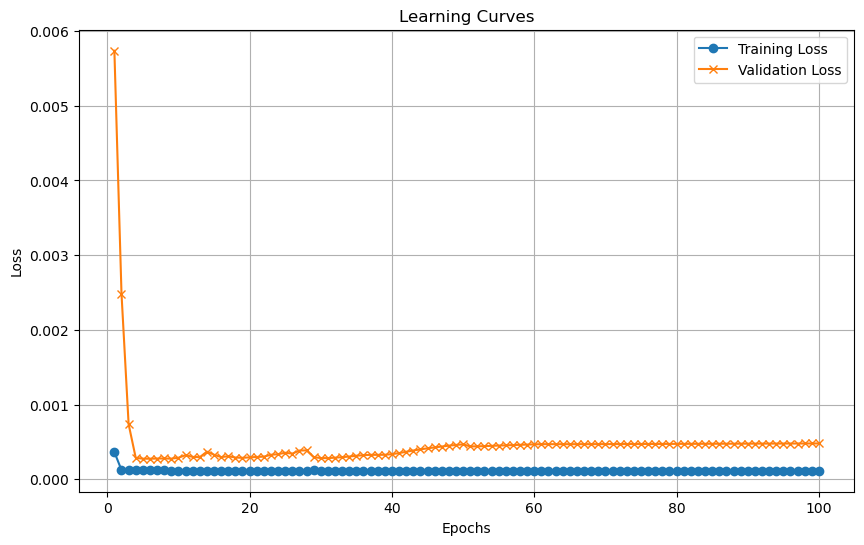

In [4]:
from src.train.trainer import Trainer
from src.train.utils import plot_learning_curves
from src.utils import google_colab_handler

running_in_colab, use_TPU, path, device = google_colab_handler(use_TPU=False, verbose=True)

trainer = Trainer(model=model,
                  device=device,
                  verbose=True,
                  running_in_colab=running_in_colab,
                  use_TPU=use_TPU,
                  use_tensorboard=True)

trainer.train(train_loader=train_loader,
                    val_loader=val_loader,
                    epochs=100,
                    lr=0.001,
                    no_change_patience=100,
                    overfit_patience=100,
                    warmup=10,
                    save_best=True)

plot_learning_curves(trainer.state.train_losses, trainer.state.val_losses)